
===== BONE INTERVAL FRAME SCORES (DEBUG) =====

Bone 1: frames 41–87
frame | energy | edgeD | score
   41 | 0.0369 | 0.0155 | 0.00057
   42 | 0.0470 | 0.0165 | 0.00077
   43 | 0.0547 | 0.0174 | 0.00095
   44 | 0.0579 | 0.0179 | 0.00104
   45 | 0.0603 | 0.0170 | 0.00103
   46 | 0.0609 | 0.0177 | 0.00108
   47 | 0.0587 | 0.0170 | 0.00100
   48 | 0.0531 | 0.0143 | 0.00076
   49 | 0.0456 | 0.0118 | 0.00054
   50 | 0.0395 | 0.0096 | 0.00038
   51 | 0.0342 | 0.0106 | 0.00036
   52 | 0.0332 | 0.0126 | 0.00042
   53 | 0.0368 | 0.0124 | 0.00046
   54 | 0.0449 | 0.0210 | 0.00094
   55 | 0.0532 | 0.0280 | 0.00149
   56 | 0.0588 | 0.0312 | 0.00183
   57 | 0.0660 | 0.0322 | 0.00212
   58 | 0.0720 | 0.0358 | 0.00257
   59 | 0.0727 | 0.0325 | 0.00236
   60 | 0.0714 | 0.0293 | 0.00209
   61 | 0.0696 | 0.0310 | 0.00216
   62 | 0.0676 | 0.0291 | 0.00197
   63 | 0.0667 | 0.0340 | 0.00227
   64 | 0.0663 | 0.0335 | 0.00222
   65 | 0.0660 | 0.0317 | 0.00210
   66 | 0.0659 | 0.0311 | 0.00205
   67 | 0.0659 

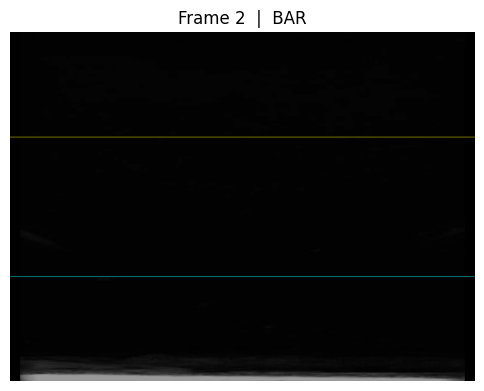

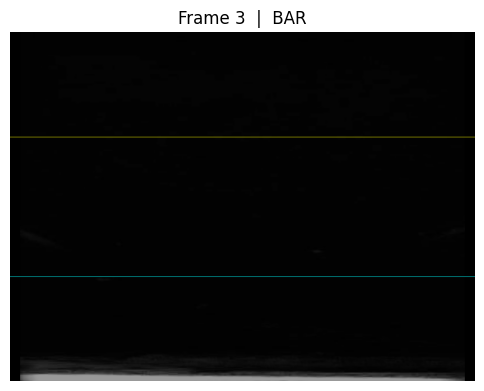

****************************
subject name -- K02
****************************

Detected BAR-1 intervals:
BAR 1 : 1 to 40
BAR 2 : 88 to 104
BAR 3 : 139 to 153
BAR 4 : 193 to 258
BAR 5 : 297 to 311
BAR 6 : 346 to 350

Detected Bone intervals:
Bone 1 : 41 - 87
Bone 2 : 105 - 138
Bone 3 : 154 - 192
Bone 4 : 259 - 296
Bone 5 : 312 - 345


In [3]:
# debug_energy_intervals.py
import numpy as np
import cv2 as cv
import pydicom
import matplotlib.pyplot as plt
import os

def edge_density(roi, low=50, high=150):
    roi_u8 = (roi * 255).astype(np.uint8)
    edges = cv.Canny(roi_u8, low, high)
    return float(np.count_nonzero(edges)) / edges.size

def pick_best_frame_from_bone_interval(arr, bone_interval,
                                       roi_top_frac=0.30,
                                       roi_bottom_frac=0.70):
    """
    Select best frame inside a bone interval using
    energy * edge density peak.
    
    arr : np.ndarray [N,H,W]
    bone_interval : (start_frame, end_frame)  (1-based, inclusive)
    """

    s, e = bone_interval
    s0, e0 = s - 1, e - 1   # to 0-based

    H, W = arr.shape[1], arr.shape[2]
    roi_y1 = int(roi_top_frac * H)
    roi_y2 = int(roi_bottom_frac * H)

    best_score = -1
    best_frame = None

    for f in range(s0, e0 + 1):
        frame = arr[f].astype(np.float32)

        # normalize
        fmin, fmax = frame.min(), frame.max()
        frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

        roi = frame_n[roi_y1:roi_y2, :]

        energy = float(np.mean(roi))
        eD = edge_density(roi)

        score = energy * eD

        if score > best_score:
            best_score = score
            best_frame = f + 1   # back to 1-based

    return best_frame

def detect_bar1_regions_debug(dicom_path,
                              start_f=1,
                              end_f=350,
                              roi_top_frac=0.30,
                              roi_bottom_frac=0.70,
                              bright_ratio=0.55,
                              width_ratio=0.40,
                              smooth_len=4,
                              show_frames=[x for x in range(2,4)]):
    """
    Standalone Bar-1 detector.
    NO SAVING. Notebook-friendly visualization.
    """

    ds = pydicom.dcmread(dicom_path)
    arr = ds.pixel_array

    # Normalize to [N,H,W]
    if arr.ndim == 2:
        arr = arr[None, ...]
    if arr.ndim == 4:
        arr = arr[..., 0]

    N = arr.shape[0]
    #end_f = min(end_f, N)
    if end_f is None:
        end_f = N
    else:
        end_f = min(end_f, N)

    frames = range(start_f - 1, end_f)

    bar_mask = np.zeros(len(frames), dtype=bool)
    # ---- COLLECT FRAME SIGNALS (NO BAR DECISION HERE) ----
    signals = { "width_ratio": [], "edgeD": [], "energy": []}

    H, W = arr.shape[1], arr.shape[2]
    roi_y1 = int(roi_top_frac * H)
    roi_y2 = int(roi_bottom_frac * H)

    #print("\nFrame | max_run | thresh | BAR")
    #print("--------------------------------")

    vis_data = {}
    prev_roi_energy = None

    for idx, f in enumerate(frames):
        frame = arr[f].astype(np.float32)

        # Normalize intensity
        fmin, fmax = frame.min(), frame.max()
        frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

        roi = frame_n[roi_y1:roi_y2, :]

        # ----- NEW: detect empty ROI -----
        roi_energy = np.mean(roi)

        if roi_energy < 0.015:   # you can tune to 0.015–0.03
            is_bar = True
            max_run = 0
            vis_mask = np.zeros_like(roi, dtype=np.uint8)
            # ---- IMPORTANT: KEEP SIGNAL LENGTH CONSISTENT ----
            signals["width_ratio"].append(1.0)   # bars dominate width
            signals["edgeD"].append(0.0)          # smooth
            signals["energy"].append(roi_energy)

            bar_mask[idx] = True
            #print(f"{f+1:03d}   |  EMPTY ROI |   -   | True")
            
            if (f+1) in show_frames:
                vis_data[f+1] = (frame_n, vis_mask, bar_mask[idx])
            continue

        # Dynamic brightness threshold
        thr = bright_ratio * np.max(roi)

        # Compute max contiguous width of bright region
        max_run = 0
        vis_mask = np.zeros_like(roi, dtype=np.uint8)

        for r in range(roi.shape[0]):
            row = roi[r] > thr
            run_len = 0

            for j in range(W):
                if row[j]:
                    run_len += 1
                    vis_mask[r, j] = 255
                    max_run = max(max_run, run_len)
                else:
                    run_len = 0

        if prev_roi_energy is None:
            dE = 0
        else:
            dE = roi_energy - prev_roi_energy
        
        prev_roi_energy = roi_energy
        # --- edge density ---
        edgeD = edge_density(roi)
        
        #is_bar = max_run >= width_ratio * W
        #is_bar = (max_run >= width_ratio * W) and (thr > 0.50)
        roi_mean   = float(np.mean(roi))
        roi_std    = float(np.std(roi))
        roi_max    = float(np.max(roi))
        roi_p95    = float(np.percentile(roi, 95))
        roi_energy = roi_mean

        bright_ratio_used = thr / roi_max if roi_max > 0 else 0
        width_ratio_used  = max_run / W

        #EDGE_THR = 0.03      # bars are smooth
        #DE_THR   = 0.002     # small positive allowed

        #is_bar = (max_run >= width_ratio * W) and (thr >= 0.52) and (max_run >= 300) and (edgeD <= EDGE_THR) and (dE <= DE_THR)
        #bar_mask[idx] = is_bar
        
        signals["width_ratio"].append(max_run / W)
        signals["edgeD"].append(edgeD)
        signals["energy"].append(roi_energy)

        # TEMP placeholder (real bar decision later)
        is_bar_candidate = (max_run / W) >= 0.55 and (thr >= 0.45)
        bar_mask[idx] = is_bar_candidate

        #print(f"{f+1:03d} | run={max_run:4d} {width_ratio_used:.2f} | thr={thr:.3f} | dE={dE:+.3f}| p95={roi_p95:.3f} | energy={roi_energy:.3f} | mean={roi_mean:.3f} | edgeD={edgeD:.3f} | std={roi_std:.3f} | BAR={bar_mask[idx]}")

        if (f+1) in show_frames:
            vis_data[f+1] = (frame_n, vis_mask, bar_mask[idx])

    # =====================================================
    # SUBJECT-RELATIVE BAR DECISION (CRITICAL FIX)
    # =====================================================

    widths = np.array(signals["width_ratio"])
    edges  = np.array(signals["edgeD"])
    energy = np.array(signals["energy"])

    # Robust normalization (subject-relative)
    w_med = np.median(widths)
    w_mad = np.median(np.abs(widths - w_med)) + 1e-6

    e_med = np.median(edges)
    e_mad = np.median(np.abs(edges - e_med)) + 1e-6

    width_z = (widths - w_med) / w_mad
    edge_z  = (edges  - e_med) / e_mad

    # Temporal smoothness (bars are temporally smooth)
    energy_std = np.array([
        np.std(energy[max(0,i-3):min(len(energy),i+4)])
        for i in range(len(energy))
    ])

    # FINAL BAR DECISION (SUBJECT-INVARIANT)
    L = min(len(bar_mask), len(widths))
    for i in range(L):
        if bar_mask[i]:
            continue
        if (
            widths[i] >= 0.55 and          # YOUR HARD INVARIANT
            width_z[i] > 0.6 and           # dominant structure
            edge_z[i] < 0 and           # smoother than bone
            energy_std[i] < np.median(energy_std)
        ):
            bar_mask[i] = True

    # ------------------------------------------
    #  TEMPORAL REPAIR PIPELINE (C)
    # ------------------------------------------

    raw = bar_mask.copy()
    N = len(raw)

    # T1 — Neighbor fill (1 0 1 → 1 1 1)
    filled = raw.copy()
    for i in range(1, N-1):
        if raw[i] == 0 and raw[i-1] == 1 and raw[i+1] == 1:
            filled[i] = 1

    # T2 — Temporal dilation (expand ±3)
    dilated = filled.copy()
    dilation_radius = 3
    for i in range(N):
        if filled[i]:
            left  = max(0, i - dilation_radius)
            right = min(N-1, i + dilation_radius)
            dilated[left:right+1] = True

    # T3 — Remove micro-bursts (<5 frames)
    clean = dilated.copy()

    # detect continuous segments
    segments = []
    i = 0
    while i < N:
        if clean[i] == 0:
            i += 1
            continue
        j = i
        while j+1 < N and clean[j+1] == 1:
            j += 1
        length = j - i + 1
        if length < 5:           # remove tiny noisy bars
            clean[i:j+1] = 0
        else:
            segments.append((i, j))
        i = j + 1

    # this is the final bar mask
    bar_mask_final = clean


    # ---- Convert to intervals (FINAL MASK) ----
    intervals = []
    i = 0
    while i < len(bar_mask_final):
        if not bar_mask_final[i]:
            i += 1
            continue
        j = i
        while j + 1 < len(bar_mask_final) and bar_mask_final[j+1]:
            j += 1
        intervals.append((frames[i] + 1, frames[j] + 1))
        i = j + 1
    
    # -------- COMPUTE BONE INTERVALS --------
    bone_intervals = []
    for i in range(len(intervals) - 1):
        bar_end    = intervals[i][1]
        next_start = intervals[i+1][0]

        bone_s = bar_end + 1
        bone_e = next_start - 1

        if bone_s <= bone_e:
            bone_intervals.append((bone_s, bone_e))


    print("\n===== BONE INTERVAL FRAME SCORES (DEBUG) =====")

    for b_id, (s, e) in enumerate(bone_intervals, 1):
        print(f"\nBone {b_id}: frames {s}–{e}")
        print("frame | energy | edgeD | score")

        scores = []

        for f in range(s-1, e):  # 0-based
            frame = arr[f].astype(np.float32)

            fmin, fmax = frame.min(), frame.max()
            frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

            roi = frame_n[roi_y1:roi_y2, :]

            energy = float(np.mean(roi))
            eD = edge_density(roi)
            score = energy * eD

            scores.append(score)

            print(f"{f+1:5d} | {energy:6.4f} | {eD:6.4f} | {score:7.5f}")

        # -----------------------------------------
        # ONSET-BASED FRAME SELECTION (CORRECT)
        # -----------------------------------------

        scores = np.array(scores)
        peak_idx = np.argmax(scores)
        peak_frame = s + peak_idx

        score_norm = scores / (scores.max() + 1e-8)

        ONSET_THR = 0.65
        SUSTAIN_K = 5

        selected_frame = None
        method = "onset_sustain"

        for i in range(len(score_norm) - SUSTAIN_K):
            if np.all(score_norm[i:i + SUSTAIN_K] >= ONSET_THR):
                selected_frame = s + i
                break

        if selected_frame is None:
            selected_frame = peak_frame
            method = "peak_fallback"

        print(f"--> Peak score at frame {peak_frame}")
        print(f"--> Selected frame ({method}) = {selected_frame}")
        print(f"--> Window: [{max(s, selected_frame-15)} , {min(e, selected_frame+15)}]")


    # -------- SHOW VISUAL DEBUG --------
    for fnum, (frame_n, vis_mask, is_bar) in vis_data.items():
        plt.figure(figsize=(6, 6))
        plt.title(f"Frame {fnum}  |  {'BAR' if is_bar else 'BONE'}")

        vis = cv.cvtColor((frame_n * 255).astype(np.uint8), cv.COLOR_GRAY2RGB)

        # ROI boundaries
        vis[roi_y1, :, :] = [255, 255, 0]   # top ROI boundary
        vis[roi_y2, :, :] = [0, 255, 255]   # bottom ROI boundary

        # Overlay bright mask
        mask_rgb = np.zeros_like(vis)
        mask_rgb[roi_y1:roi_y2][vis_mask == 255] = [255, 0, 0]

        overlay = cv.addWeighted(vis, 0.6, mask_rgb, 0.8, 0)
        plt.imshow(overlay)
        plt.axis("off")
        plt.show()

    return bar_mask_final, intervals, bone_intervals, arr

dicom_path = "/home/ds/Desktop/Hand_dicom/K02.dcm"
subject_name =  os.path.splitext(os.path.basename(dicom_path))[0]

mask, ivals, bone_intervals, arr = detect_bar1_regions_debug(dicom_path)

print("****************************")
print(f"subject name -- {subject_name}")
print("****************************")   
print("\nDetected BAR-1 intervals:")

# Numbered BAR intervals
for idx, (s, e) in enumerate(ivals, start=1):
    print(f"BAR {idx} : {s} to {e}")

# -------- COMPUTE BONE INTERVALS --------
print("\nDetected Bone intervals:")

bone_id = 1
for i in range(len(ivals) - 1):
    bar_end   = ivals[i][1]
    next_start = ivals[i+1][0]

    bone_s = bar_end + 1
    bone_e = next_start - 1

    if bone_s <= bone_e:
        print(f"Bone {bone_id} : {bone_s} - {bone_e}")
        bone_id += 1


===== BONE INTERVAL ANALYSIS =====

=== Bone 1 ===

Bone interval 53–92
frame | mean_energy
   53 |  0.03684
   54 |  0.04491
   55 |  0.05315
   56 |  0.05877
   57 |  0.06597
   58 |  0.07200
   59 |  0.07273
   60 |  0.07137
   61 |  0.06961
   62 |  0.06756
   63 |  0.06674
   64 |  0.06631
   65 |  0.06602
   66 |  0.06590
   67 |  0.06588
   68 |  0.06594
   69 |  0.06643
   70 |  0.06734
   71 |  0.06892
   72 |  0.07154
   73 |  0.07413
   74 |  0.07609
   75 |  0.07793
   76 |  0.08020
   77 |  0.08239
   78 |  0.08531
   79 |  0.08675
   80 |  0.08866
   81 |  0.09023
   82 |  0.09173
   83 |  0.09244
   84 |  0.09206
   85 |  0.09123
   86 |  0.08920
   87 |  0.08628
   88 |  0.08114
   89 |  0.08511
   90 |  0.09763
   91 |  0.10894
   92 |  0.11639
--> Flat high-energy band: [81 , 85]
--> Output window: [73 , 93]

=== Bone 2 ===

Bone interval 104–139
frame | mean_energy
  104 |  0.05164
  105 |  0.06131
  106 |  0.07047
  107 |  0.07375
  108 |  0.07183
  109 |  0.06840


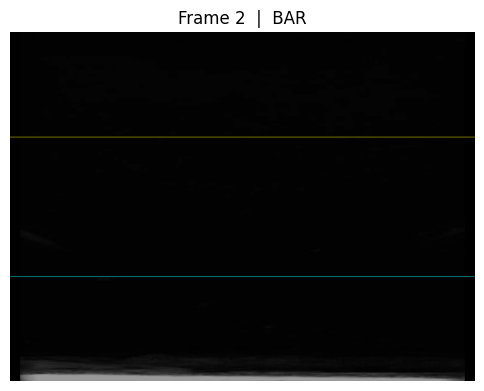

****************************
subject name -- K02
****************************

Detected BAR-1 intervals:
BAR 1 : 1 to 52
BAR 2 : 93 to 103
BAR 3 : 140 to 152
BAR 4 : 185 to 255
BAR 5 : 298 to 310
BAR 6 : 338 to 344
BAR 7 : 346 to 360
BAR 8 : 483 to 504
BAR 9 : 543 to 553
BAR 10 : 581 to 591
BAR 11 : 593 to 628
BAR 12 : 905 to 928

Detected Bone intervals:
Bone 1 : 53 to 92
Bone 2 : 104 to 139
Bone 3 : 153 to 184
Bone 4 : 256 to 297
Bone 5 : 311 to 337
Bone 6 : 345 to 345
Bone 7 : 361 to 482
Bone 8 : 505 to 542
Bone 9 : 554 to 580
Bone 10 : 592 to 592
Bone 11 : 629 to 904


In [4]:
import numpy as np
import cv2 as cv
import pydicom
import matplotlib.pyplot as plt
import os


def analyze_bone_interval(arr, bone_interval,
                          roi_y1, roi_y2,
                          sustain_k=5,
                          onset_frac=0.65):
    """
    Analyze one bone interval and find onset-based bone frame
    """

    s, e = bone_interval
    scores = []

    print(f"\nBone interval {s}–{e}")
    print("frame | mean_energy")

    if e - s + 1 <= 2:
        print(f"--> Trivial interval, using center frame {s}")
        print(f"--> Window: [{s} , {s}]")
        return s

    for f in range(s-1, e):   # 0-based
        frame = arr[f].astype(np.float32)

        fmin, fmax = frame.min(), frame.max()
        frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

        roi = frame_n[roi_y1:roi_y2, :]
        energy = float(np.mean(roi))

        scores.append(energy)
        print(f"{f+1:5d} | {energy:8.5f}")

    scores = np.array(scores)
    ENERGY_FLOOR = 0.05

    if scores.max() < ENERGY_FLOOR:
        print(f"--> Dropped interval (low energy): max={scores.max():.4f}")
        return None
    N = len(scores)

    # --- temporal derivative ---
    dE = np.zeros_like(scores)
    if N > 2:
        dE[1:-1] = np.abs(scores[2:] - scores[:-2]) / 2
        dE[0] = dE[1]
        dE[-1] = dE[-2]
    else:
        dE[:] = 0

    # --- thresholds (SUBJECT RELATIVE, NOT ABSOLUTE) ---
    HIGH_ENERGY_THR = 0.85 * np.percentile(scores, 95)
    FLAT_THR = np.percentile(dE, 40)   # low variation

    mask = (scores >= HIGH_ENERGY_THR) & (dE <= FLAT_THR)

    idxs = np.where(mask)[0]

    if len(idxs) > 0:
        segments = np.split(
            idxs,
            np.where(np.diff(idxs) != 1)[0] + 1
        )

        # choose longest flat high-energy band
        # reject bands hugging interval edges
        VALID_MARGIN = 0.15 * (e - s + 1)

        valid_segs = []
        for seg in segments:
            seg_start = s + seg[0]
            seg_end   = s + seg[-1]
            if (seg_start - s) > VALID_MARGIN and (e - seg_end) > VALID_MARGIN:
                valid_segs.append(seg)

        if len(valid_segs) > 0:
            # Prefer band closest to next bar (late bone region)
            best_seg = max(
                valid_segs,
                key=lambda seg: (seg[-1])   # highest frame index
            )
        else:
            best_seg = max(segments, key=len)


        seg_start = s + best_seg[0]
        seg_end   = s + best_seg[-1]

        center = (seg_start + seg_end) // 2

        print(f"--> Flat high-energy band: [{seg_start} , {seg_end}]")
        print(f"--> Output window: [{center-10} , {center+10}]")
    else:
        center = s + np.argmax(scores)
        print(f"--> Fallback window: [{center-10} , {center+10}]")

    return center

def detect_bar1_regions_debug(dicom_path,
                              start_f=1,
                              end_f=None,
                              roi_top_frac=0.30,
                              roi_bottom_frac=0.70,
                              bright_ratio=0.55,
                              width_ratio=0.40,
                              smooth_len=5,
                              show_frames=[x for x in range(2,3)]):
    """
    Standalone Bar-1 detector.
    NO SAVING. Notebook-friendly visualization.
    """

    ds = pydicom.dcmread(dicom_path)
    arr = ds.pixel_array

    # Normalize to [N,H,W]
    if arr.ndim == 2:
        arr = arr[None, ...]
    if arr.ndim == 4:
        arr = arr[..., 0]

    N = arr.shape[0]
    #end_f = min(end_f, N)
    if end_f is None:
        end_f = N
    else:
        end_f = min(end_f, N)

    frames = range(start_f - 1, end_f)

    bar_mask = np.zeros(len(frames), dtype=bool)

    H, W = arr.shape[1], arr.shape[2]
    roi_y1 = int(roi_top_frac * H)
    roi_y2 = int(roi_bottom_frac * H)

    #print("\nFrame | max_run | thresh | BAR")
    #print("--------------------------------")

    vis_data = {}

    for idx, f in enumerate(frames):
        frame = arr[f].astype(np.float32)

        # Normalize intensity
        fmin, fmax = frame.min(), frame.max()
        frame_n = (frame - fmin) / (fmax - fmin + 1e-6)

        roi = frame_n[roi_y1:roi_y2, :]

        # ----- NEW: detect empty ROI -----
        roi_energy = np.mean(roi)

        if roi_energy < 0.02:   # you can tune to 0.015–0.03
            is_bar = True
            max_run = 0
            vis_mask = np.zeros_like(roi, dtype=np.uint8)
            bar_mask[idx] = True
            #print(f"{f+1:03d}   |  EMPTY ROI |   -   | True")
            
            if (f+1) in show_frames:
                vis_data[f+1] = (frame_n, vis_mask, is_bar)
            continue

        # Dynamic brightness threshold
        thr = bright_ratio * np.max(roi)

        # Compute max contiguous width of bright region
        max_run = 0
        vis_mask = np.zeros_like(roi, dtype=np.uint8)

        for r in range(roi.shape[0]):
            row = roi[r] > thr
            run_len = 0

            for j in range(W):
                if row[j]:
                    run_len += 1
                    vis_mask[r, j] = 255
                    max_run = max(max_run, run_len)
                else:
                    run_len = 0

        #is_bar = max_run >= width_ratio * W
        #is_bar = (max_run >= width_ratio * W) and (thr > 0.50)
        roi_mean   = float(np.mean(roi))
        roi_std    = float(np.std(roi))
        roi_max    = float(np.max(roi))
        roi_p95    = float(np.percentile(roi, 95))
        roi_energy = roi_mean

        bright_ratio_used = thr / roi_max if roi_max > 0 else 0
        width_ratio_used  = max_run / W

        is_bar = (max_run >= width_ratio * W) and (thr >= 0.52) and (max_run >= 300)
        bar_mask[idx] = is_bar

        #print(f"{f+1:03d} | run={max_run:4d} {width_ratio_used:.2f} | thr={thr:.3f} | p95={roi_p95:.3f} | mean={roi_mean:.3f} | std={roi_std:.3f} | BAR={is_bar}")

        if (f+1) in show_frames:
            vis_data[f+1] = (frame_n, vis_mask, is_bar)

    # ------------------------------------------
    #  TEMPORAL REPAIR PIPELINE (C)
    # ------------------------------------------

    raw = bar_mask.copy()
    N = len(raw)

    # T1 — Neighbor fill (1 0 1 → 1 1 1)
    filled = raw.copy()
    for i in range(1, N-1):
        if raw[i] == 0 and raw[i-1] == 1 and raw[i+1] == 1:
            filled[i] = 1

    # T2 — Temporal dilation (expand ±3)
    dilated = filled.copy()
    dilation_radius = 3
    for i in range(N):
        if filled[i]:
            left  = max(0, i - dilation_radius)
            right = min(N-1, i + dilation_radius)
            dilated[left:right+1] = True

    # T3 — Remove micro-bursts (<5 frames)
    clean = dilated.copy()

    # detect continuous segments
    segments = []
    i = 0
    while i < N:
        if clean[i] == 0:
            i += 1
            continue
        j = i
        while j+1 < N and clean[j+1] == 1:
            j += 1
        length = j - i + 1
        if length < 5:           # remove tiny noisy bars
            clean[i:j+1] = 0
        else:
            segments.append((i, j))
        i = j + 1

    # this is the final bar mask
    bar_mask_final = clean


    # ---- Convert to intervals (FINAL MASK) ----
    intervals = []
    i = 0
    while i < len(bar_mask_final):
        if not bar_mask_final[i]:
            i += 1
            continue
        j = i
        while j + 1 < len(bar_mask_final) and bar_mask_final[j+1]:
            j += 1
        intervals.append((frames[i] + 1, frames[j] + 1))
        i = j + 1
    
    # -------- COMPUTE BONE INTERVALS INSIDE FUNCTION --------
    bone_intervals = []
    for i in range(len(intervals) - 1):
        bar_end   = intervals[i][1]
        next_start = intervals[i+1][0]

        bone_s = bar_end + 1
        bone_e = next_start - 1

        if bone_s <= bone_e:
            bone_intervals.append((bone_s, bone_e))
    
    print("\n===== BONE INTERVAL ANALYSIS =====")

    for b_id, (bone_s, bone_e) in enumerate(bone_intervals, 1):
        print(f"\n=== Bone {b_id} ===")
        analyze_bone_interval(
            arr,
            (bone_s, bone_e),
            roi_y1,
            roi_y2,
            sustain_k=5,
            onset_frac=0.65
        )

    # -------- SHOW VISUAL DEBUG --------
    for fnum, (frame_n, vis_mask, is_bar) in vis_data.items():
        plt.figure(figsize=(6, 6))
        plt.title(f"Frame {fnum}  |  {'BAR' if is_bar else 'BONE'}")

        vis = cv.cvtColor((frame_n * 255).astype(np.uint8), cv.COLOR_GRAY2RGB)

        # ROI boundaries
        vis[roi_y1, :, :] = [255, 255, 0]   # top ROI boundary
        vis[roi_y2, :, :] = [0, 255, 255]   # bottom ROI boundary

        # Overlay bright mask
        mask_rgb = np.zeros_like(vis)
        mask_rgb[roi_y1:roi_y2][vis_mask == 255] = [255, 0, 0]

        overlay = cv.addWeighted(vis, 0.6, mask_rgb, 0.8, 0)
        plt.imshow(overlay)
        plt.axis("off")
        plt.show()

    return bar_mask_final, intervals

dicom_path = "/home/ds/Desktop/Hand_dicom/K02.dcm"
subject_name =  os.path.splitext(os.path.basename(dicom_path))[0]
#  RUN
mask, ivals = detect_bar1_regions_debug(dicom_path)

print("****************************")
print(f"subject name -- {subject_name}")
print("****************************")
print("\nDetected BAR-1 intervals:")

# Numbered BAR intervals
for idx, (s, e) in enumerate(ivals, start=1):
    print(f"BAR {idx} : {s} to {e}")
    
# -------- COMPUTE BONE INTERVALS --------
print("\nDetected Bone intervals:")

bone_id = 1
for i in range(len(ivals) - 1):
    bar_end   = ivals[i][1]
    next_start = ivals[i+1][0]

    bone_s = bar_end + 1
    bone_e = next_start - 1

    if bone_s <= bone_e:
        print(f"Bone {bone_id} : {bone_s} to {bone_e}")
        bone_id += 1



In [ ]:
338 to 345
345 is not a bone 
592 is not a bone 
